# Random Forest for Breast Cancer Dataset

Este cuaderno busca mostrar el método de clasificación de Random Forest, haciendo la comparativa con la performance de los arboles de decisión normales. Para ello se utilizará el dataset de ``sklearn.datasets`` de ``breast_cancer``. Se buscará hacer un clasificador para obtener a partir de un conjunto de features si un tumor es benigno o maligno.

In [1]:
#Se  importan librerias generales para el manejo de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

## Carga y Preparación del Dataset

In [2]:
#Cargamos el dataset
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)
data = pd.DataFrame(data['frame'])

X = data.drop(columns=['target']) # El espacio de features
y = data.target                   # La clasificacion correspondiente

In [3]:
# Cambiar el 0 y 1 por B ('Benigno') y M ('Maligno')
data['target'][data['target']==0] = 'B'
data['target'][data['target']==1] = 'M'

<ipython-input-3-f38a8f12ecb7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'][data['target']==0] = 'B'


Vemos cuánto hay de cada clasificación. 

In [5]:
data.target.value_counts()

M    357
B    212
Name: target, dtype: int64

Notamos que no esta balanceado el dataset y es mayor el numero de elementos correspondientes a M.

Mostramos todas las columnas disponibles del dataset

In [6]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

Para los distintos items, de cada uno aparece un valor promedio, uno de error y uno de la peor condición medida del item. Aqui dejamos un código para graficar por elemento.

<ipython-input-7-411cb8b0c5f7>:10: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  plt.scatter(X.loc[:,col_x],X.loc[:,col_y],c=data.target, cmap='Pastel1')


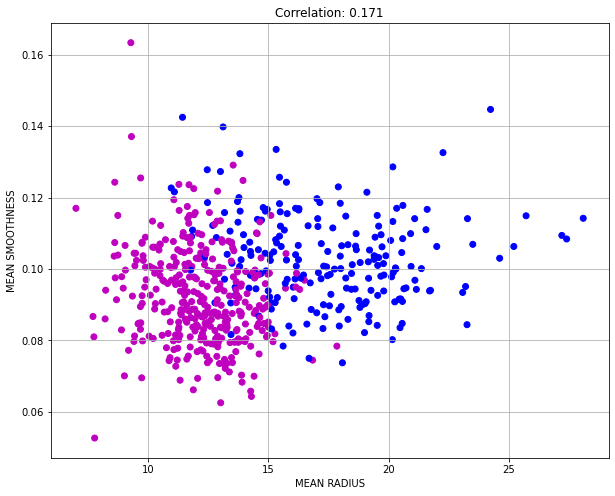

In [7]:
col_x= 'mean radius'
col_y= 'mean smoothness'
corr = X.corr().loc[col_y,col_x]

plt.figure(figsize=(10,8))
ax = plt.axes()
#ax.set_facecolor("#F0FFFF")

plt.title(f'Correlation: {corr:.3}')
plt.scatter(X.loc[:,col_x],X.loc[:,col_y],c=data.target)
plt.xlabel(col_x.upper())
plt.ylabel(col_y.upper())
plt.grid()

Vemos la correlación de los elementos

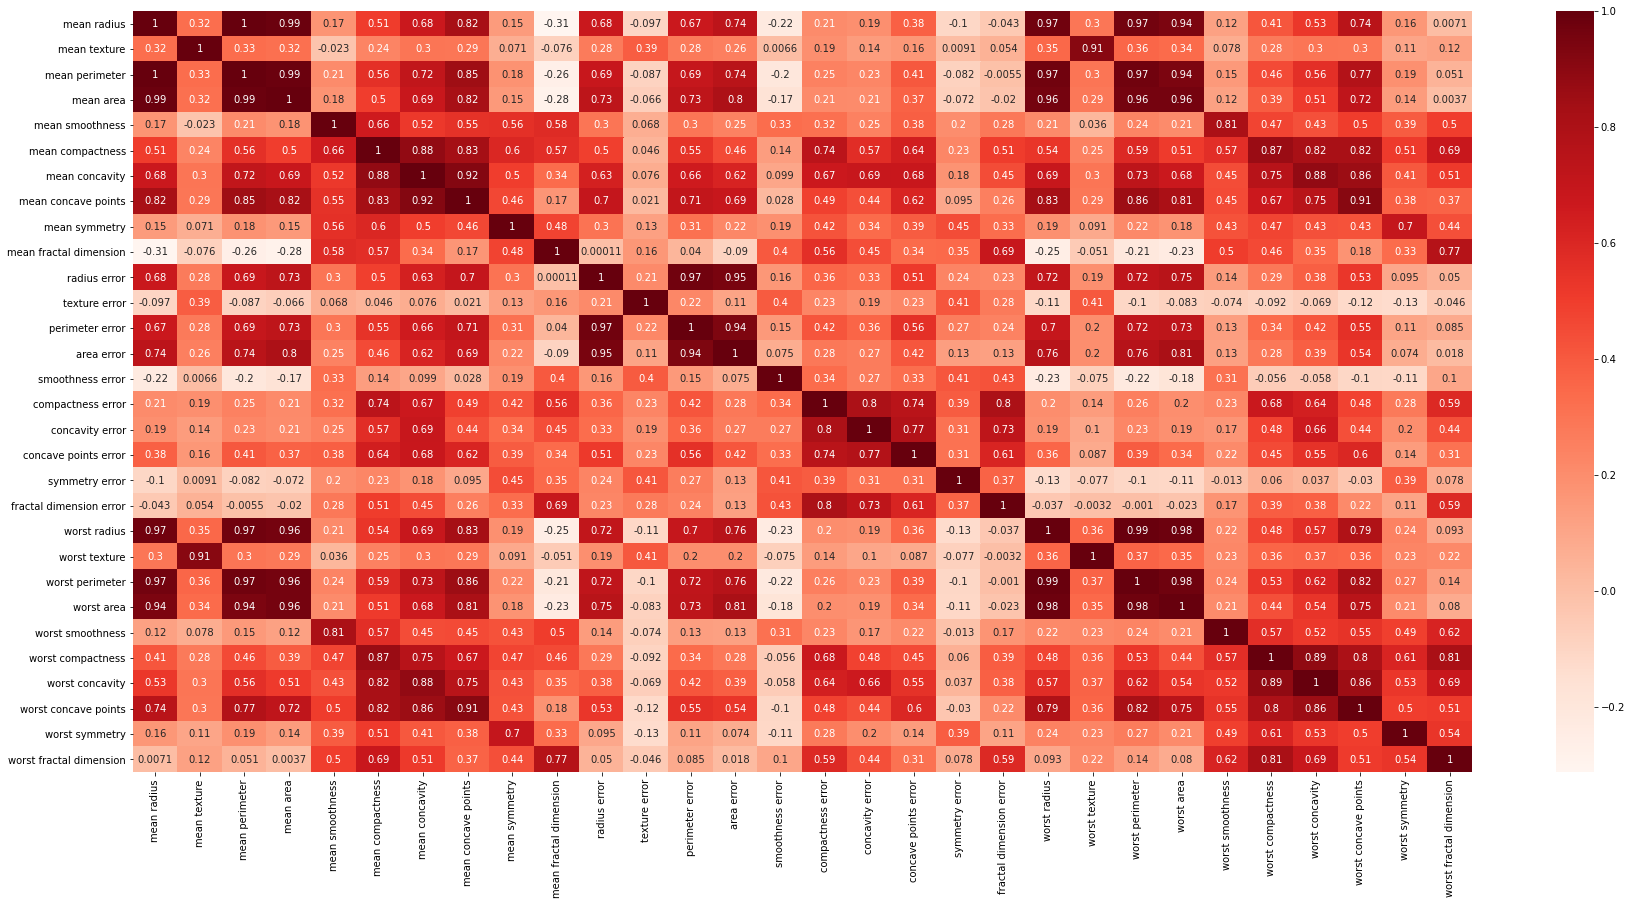

In [12]:
plt.figure(figsize=(30,14))
sbn.heatmap(X.corr(),annot=True,cmap='Reds')

Hay muchos elementos que tienen alta correlación. Eso permitiría pensar que no todas las columnas del dataset son relevantes para construir el clasificador. Si aplicaramos una regresion logística, una de las hipótesis del desarrollo corresponde a que las variables de cada punto son aleatorias e independientes. Podria hacerse PCA para reducir la dimensionalidad del dataset. Pero una de las ventajas de arboles de decisión es que selecciona los features jerárquicamente según mayor importancia, por lo que no es necesario dicha reducción *a priori*

## Arboles de Decision

Empezamos por mostrar la performance de un arbol de decisión común. Un Arbol de Decisión es una estructura jerárquica de nodos, como en un diagrama de flujo, que se va ramificando a distintas 'hojas' dependiendo de si los datos que se insertan cumplen o no determinadas condiciones. El algoritmo busca los features que mas minimizan la entropía de los nodos, por lo que eso permite evitar tener que tratar previamente la correlación de las variables. Aparte, tiene la ventaja de que presenta intuitivamente la clasificación. Esto es útil para dar interpretabilidad al modelo. 

In [8]:
from sklearn.tree import DecisionTreeClassifier # Arboles de decisión para clasificación
from sklearn.tree import plot_tree # Función para visualizar el árbol

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler #Normalizado de los datos para mejor performance
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #Para mostrar la matriz de confusion y evaluar resultados

from sklearn.ensemble import RandomForestClassifier # Random forests para clasificación

Dividimos en train y set

In [9]:
random_seed = 123475
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = random_seed)

Ahora llamamos al clasificador y desarrollamos un pipeline para que reescale primero los datos y luego entrene el algoritmo

In [18]:
dtc = DecisionTreeClassifier(max_depth=5, class_weight='balanced') 

pip = Pipeline([('scaler', StandardScaler()), ('dtc', dtc)])
pip.fit(X_train,y_train)
y_pred = pip.predict(X_test)

#Vemos que resultados se obtienen en cada set
print('En Train: ',pip.score(X_train,y_train))
print('En Test: ', pip.score(X_test,y_test))



En Train:  0.9974874371859297
En Test:  0.9298245614035088


Notese que el resultado es muy bueno en el Train, pero en el Test no tanto. Por lo general los algoritmos de Arboles de Decisión tienden a sobreajustar datos. Por otro lado queremos ver, como es un clasificador para detección de cancer, que resultados se obtienen. Particularmente, hay que no solo minimizar el error de clasificación, sino también considerar la tasa de falsos negativos, pues aquellos casos malignos mal diagnosticados como benignos pueden tener consecuencias mas graves que su contraparte

In [19]:
#False negative rate
def FNR(cm):
    return cm[1,0]/(cm[1,0]+cm[1,1]) # Expresa el ratio FN/(FN + TP)

La tasa de Falsos Negativos:  0.036036036036036036


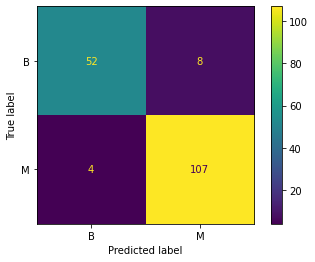

In [17]:
#Muestra la matriz de confusion
cm = confusion_matrix(y_test,y_pred, labels=pip.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=pip.classes_)
disp.plot()

print('La tasa de Falsos Negativos: ', FNR(cm))   

Veamos los features mas importantes

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

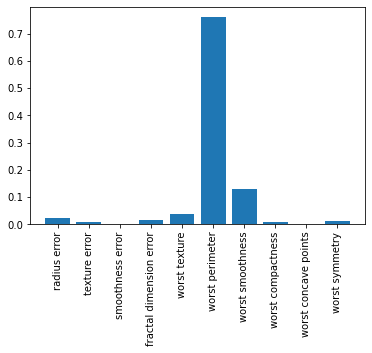

In [23]:
feat = pip.named_steps['dtc'].feature_importances_
plt.bar(X.columns[feat>0], feat[feat>0])
plt.xticks(rotation=90)

Gran parte de la fuerza predictiva del algoritmo proviene de un solo feature. Visualizemos el arbol

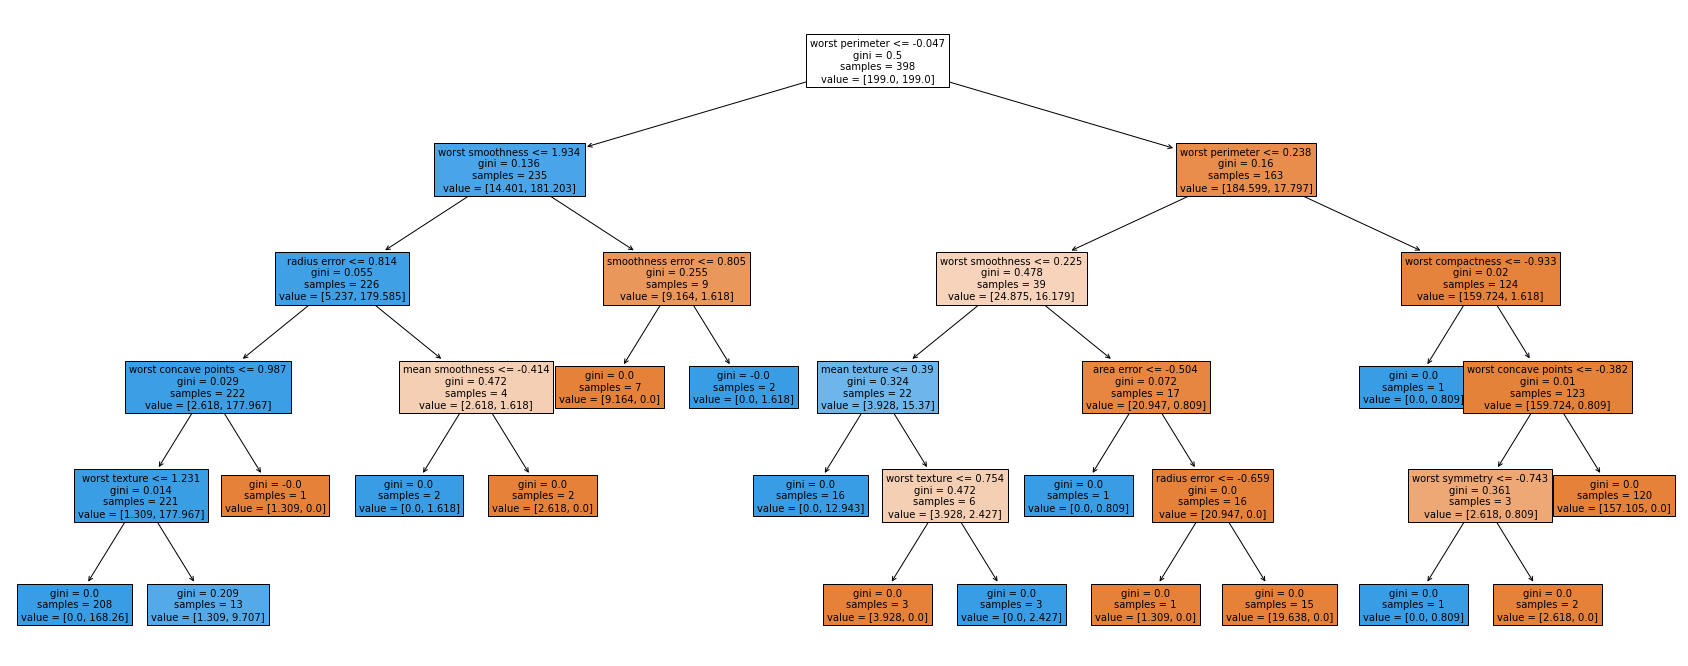

In [23]:
plt.figure(figsize=(30,12))
plot_tree(pip.named_steps['dtc'], feature_names=X.columns, fontsize = 10, filled = True)
plt.show()

## Grid Search

Vamos a tratar de optimizar hiperparámetros para ver si hay un mejor resultado posible

In [24]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold #Importa un metodo de busqueda en una grilla
                                                                          #Con un metodo de Cross Validation

In [25]:
#Escalamos los datos aparte para hacer el gridsearch
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train_ = std_scale.transform(X_train)

std_scale.fit(X_test)
X_test_ = std_scale.transform(X_test)

In [26]:
dic = {'max_depth':[3,5,6,7,9,11], 'ccp_alpha': [1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]} #Grilla de valores

cv = RepeatedStratifiedKFold(n_splits=3, random_state=0)

clf = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=dic,cv=cv)

In [27]:
clf.fit(X_train_,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=0),
             estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'ccp_alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2,
                                       5],
                         'max_depth': [3, 5, 6, 7, 9, 11]})

In [28]:
ccp, maxd = clf.best_params_.values() #Mejores parametros obtenidos
print('Los mejores parametros: ', clf.best_params_)
print('El score correspondiente: ',clf.best_score_)


Los mejores parametros:  {'ccp_alpha': 1e-05, 'max_depth': 7}
El score correspondiente:  0.9175856307435255


In [29]:
dtc= DecisionTreeClassifier(max_depth=maxd, ccp_alpha=ccp, class_weight='balanced')

pip = Pipeline([('scaler', StandardScaler()), ('dtc', dtc)])
pip.fit(X_train,y_train)

print('En Train: ',pip.score(X_train,y_train))
print('En Test: ', pip.score(X_test,y_test))

En Train:  1.0
En Test:  0.9239766081871345


Tasa de falsos negativos:  0.036036036036036036


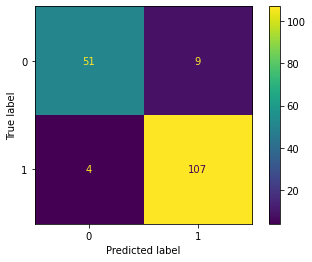

In [30]:
cm = confusion_matrix(y_test,pip.predict(X_test), labels=dtc.classes_)  
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print('Tasa de falsos negativos: ', FNR(cm)) 

La tasa de falsos negativos es similar a la de antes y el score en el test también

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

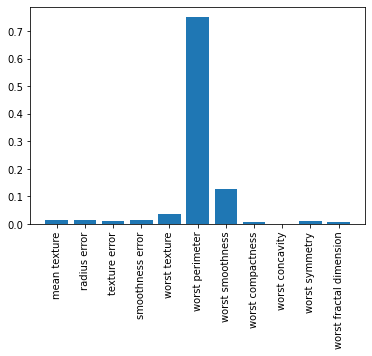

In [31]:
feat = pip.named_steps['dtc'].feature_importances_
plt.bar(X.columns[feat>0], feat[feat>0])
plt.xticks(rotation=90)

Sigue teniendo un parámetro como predictor fuerte. Veamos en varias iteraciones cual es la tasa de falsos negativos.

In [32]:
iteraciones = 40
fnr_array = np.zeros(iteraciones)
mean_feature_importance = np.zeros(30)
for i in range(40):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

    dtc= DecisionTreeClassifier(max_depth=maxd, ccp_alpha=ccp, class_weight='balanced')

    pip = Pipeline([('scaler', StandardScaler()), ('dtc', dtc)])
    pip.fit(X_train,y_train)

    cm = confusion_matrix(y_test,pip.predict(X_test), labels=dtc.classes_)  
    
    fnr_array[i] = FNR(cm)
    mean_feature_importance = mean_feature_importance + dtc.feature_importances_/iteraciones

print(fnr_array.mean(),fnr_array.std())



0.06213825893928522 0.02823254006430395


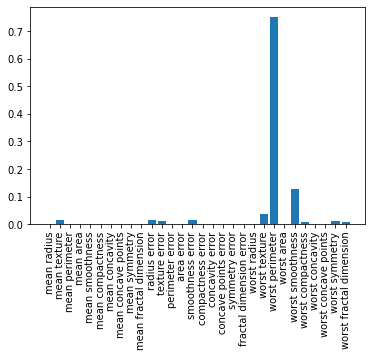

In [33]:
plt.bar(X.columns[mean_feature_importance>0], feat[mean_feature_importance>0])
plt.xticks(rotation=90)
plt.show()

## Random Forest

La tasa de falsos negativos resulta sercana al 6%. Tambien se nota un caso de un predictor demasiado fuerte en la clasificacion. Esto puede traer problemas de performance. Por lo tanto aplicamos el algoritmo Random Forest. Este hace varios arboles con un conjunto aleatorio de datos de entrenamiento (bootstraping), seleccionando tambien al azar un conjunto de features. Luego se entrena el algorimo haciendo clasificadores con varios de esos arboles y para dar un resultado final por votacion entre los arboles. La desventaja del metodo es que se pierde interpretabilidad, ademas que el costo computacional es mayor.

In [34]:
random_seed = 123475
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = random_seed)

rfc = RandomForestClassifier(max_depth=5, class_weight='balanced') #Clasificador random forest

pip = Pipeline([('scaler', StandardScaler()), ('rfc', rfc)])
pip.fit(X_train,y_train)

pip.fit(X_train, y_train)
y_pred=pip.predict(X_test)
print('En Train: ', pip.score(X_train, y_train))
print('En Test: ', pip.score(X_test, y_test))


En Train:  0.9974874371859297
En Test:  0.9532163742690059


El score para el mismo test set que en la seccion de arboles de decision es mejor

Tasa de falsos negativos:  0.018018018018018018


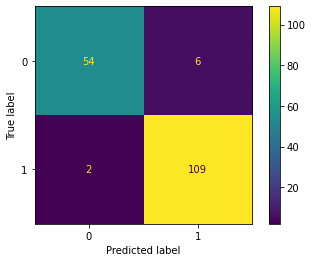

In [35]:
cm = confusion_matrix(y_test,pip.predict(X_test), labels=dtc.classes_)  
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print('Tasa de falsos negativos: ', FNR(cm)) 

Tambien hay una buena respuesta de la tasa de falsos negativos

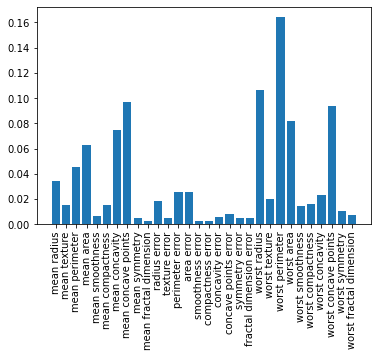

In [36]:
feature_importance = pip.named_steps["rfc"].feature_importances_
plt.bar(X.columns[feature_importance>0], feature_importance[feature_importance>0])
plt.xticks(rotation=90)
plt.show()

Aca esta lo distinto a lo ejemplos anteriores. No hay un predictor dominante frente a los otros. El predictor de mayor importancia en arboles de decisión y en Random Forest es el mismo. No obstante hay mas peso de los demas en este último. Hacemos una grid-search también para Random Forest.

In [37]:
dic = {'max_depth':[3,5,6,7,9,11], 'ccp_alpha': [1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]}
cv = RepeatedStratifiedKFold(n_splits=3, random_state=0)
clf = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid=dic,cv=cv)

In [39]:
std = StandardScaler()
std.fit(X_train)
X_train_ = std.transform(X_train)
clf.fit(X_train_,y_train)

ccp, maxd = clf.best_params_.values()
print('Los mejores parametros: ', clf.best_params_)
print('El score correspondiente: ',clf.best_score_)

Los mejores parametros:  {'ccp_alpha': 0.0001, 'max_depth': 9}
El score correspondiente:  0.9595598845598846


Vemos los resultados ahora

In [40]:
random_seed = 123475
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = random_seed)

rfc = RandomForestClassifier(max_depth=maxd, ccp_alpha=ccp,class_weight='balanced')

pip = Pipeline([('scaler', StandardScaler()), ('rfc', rfc)])
pip.fit(X_train,y_train)

pip.fit(X_train, y_train)

print('En Train: ', pip.score(X_train, y_train))
print('En Test: ', pip.score(X_test, y_test))

En Train:  1.0
En Test:  0.9590643274853801


Tasa de falsos negativos:  0.018018018018018018


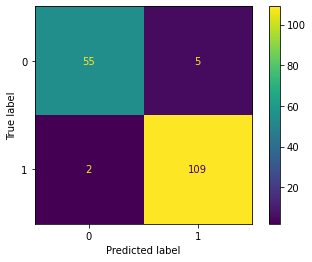

In [41]:
cm = confusion_matrix(y_test,pip.predict(X_test), labels=dtc.classes_)  
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print('Tasa de falsos negativos: ', FNR(cm)) 

In [42]:
iteraciones = 40
fnr_array = np.zeros(iteraciones)
mean_feature_importance = np.zeros(30)
for i in range(40):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

    rfc = RandomForestClassifier(max_depth=9, ccp_alpha=1e-05)

    pip = Pipeline([('scaler', StandardScaler()), ('rfc', rfc)])
    pip.fit(X_train,y_train)

    pip.fit(X_train, y_train)
    cm = confusion_matrix(y_test,pip.predict(X_test), labels=dtc.classes_)  
    
    fnr_array[i] = FNR(cm)
    mean_feature_importance = mean_feature_importance + dtc.feature_importances_/iteraciones

print(fnr_array.mean(),fnr_array.std())

0.028577181104103667 0.017178649045372783


La tasa de Falsos Negativos es menor a la de arboles normales.